### La lecture de la base de données

In [151]:
import pandas as pd
import numpy as np

#Lecture du fichier après téléchargement
df=pd.read_csv('C:/Users/libiscarrat/Downloads/Dataset - Ads _ Levallois-Perret - 2019-08 - export-ads-levallois-perret-2019-08-27.csv')

df=df.fillna(0)

#Je convertis différentes spécifictés de chaque bien en un entier que mon code pourra lire
df.loc[df['DEALER_TYPE'] =="AGENCY", 'DEALER_TYPE'] = 100
df.loc[df['DEALER_TYPE'] =="PRIVATE", 'DEALER_TYPE'] = 0
df.loc[df['DEALER_TYPE'] =="MANDATARY", 'DEALER_TYPE'] = 200

df.loc[df['MARKETING_TYPE'] =="SALE", 'MARKETING_TYPE'] = 1000
df.loc[df['MARKETING_TYPE'] =="RENT", 'MARKETING_TYPE'] = 0

df.loc[df['PROPERTY_TYPE'] =="APARTMENT", 'PROPERTY_TYPE'] = 0
df.loc[df['PROPERTY_TYPE'] =="BUILDING", 'PROPERTY_TYPE'] = 100
df.loc[df['PROPERTY_TYPE'] =="HOUSE", 'PROPERTY_TYPE'] = 200
df.loc[df['PROPERTY_TYPE'] =="PARKING", 'PROPERTY_TYPE'] = 300
df.loc[df['PROPERTY_TYPE'] =="PREMISES", 'PROPERTY_TYPE'] = 400

df.loc[df['HEATING_MODE'] =="COLLECTIVE", 'HEATING_MODE'] = 0
df.loc[df['HEATING_MODE'] =="INDIVIDUAL", 'HEATING_MODE'] = 10
df.loc[df['HEATING_MODE'] =="MIXED", 'HEATING_MODE'] = 20

#Je transforme l'ensemble des booléens en entiers
df=df*1

#Premier tri juste pour mettre un peu d'ordre
df.sort_values(by=['DEALER_TYPE','PROPERTY_TYPE','MARKETING_TYPE','HEATING_MODE','SURFACE','PRICE','PRICE_M2','FEES','FEES_INCLUDED','ROOM_COUNT'],
                        ignore_index=True, inplace=True)

## I/ Premier tri grâce à K-MEANS

In [161]:
from sklearn.cluster import KMeans


def elbow(df) :
    distortions = []
    i=0
    k=int(len(df)*0.5)
    b=1
    a=10
    while(abs(a-b)>0.000001):
        a=b
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
        b=distortions[i]
        k=k+1
    
    return k

In [162]:
#Pour le premier tri en utilisant KMeans de la bibliothèque sklearn qui va grouper grossièrement les biens 
#avec les caractéristiques les plus proches
kmeans = KMeans(n_clusters=elbow(df[['PROPERTY_TYPE','NEW_BUILD','FURNISHED','FIREPLACE','SURFACE','PARKING','HEATING_MODE','FLOOR','FLOOR_COUNT','ELEVATOR','MARKETING_TYPE','PRICE_M2','RENTAL_EXPENSES_INCLUDED','DEPOSIT','FEES','EXCLUSIVE_MANDATE','OCCUPIED','DEALER_TYPE']]), random_state=0).fit(df[['PROPERTY_TYPE','NEW_BUILD','FURNISHED','FIREPLACE','SURFACE','PARKING','HEATING_MODE','FLOOR','FLOOR_COUNT','ELEVATOR','MARKETING_TYPE','PRICE_M2','RENTAL_EXPENSES_INCLUDED','DEPOSIT','FEES','EXCLUSIVE_MANDATE','OCCUPIED','DEALER_TYPE']])

df["k_means_label"]=kmeans.labels_

#Affiche l'ensemble des doublons
#df.to_excel("C:/Users/libiscarrat/Downloads/output.xlsx") 

### Comme expliqué précédement, ce premier tri est assez grossier, il va juste regrouper les biens avec les caractéristiques les plus proches.

Celles-ci ont été choisies en fonction de leur caractère immuable, en effet je n'ai pas choisi de prendre en compte le prix car  le prix peut varier en fonction des sites d'annonce. (frais d'agence par exemple)

### Elles sont les suivantes :

* PROPERTY_TYPE 
* NEW_BUILD
* SURFACE
* FURNISHED 
* FIREPLACE 
* PARKING
* HEATING_MODE 
* FLOOR
* FLOOR_COUNT 
* ELEVATOR
* MARKETING_TYPE 
* PRICE_M2 
* RENTAL_EXPENSES_INCLUDED 
* DEPOSIT
* FEES 
* EXCLUSIVE_MANDATE
* OCCUPIED 
* DEALER_TYPE


### Vous pouvez ainsi voir une première version du tri qui nous retourne un nombre de groupes différents (chaque groupe est numéroté par K-Means). Le choix du nombre de groupes a été effectué par la elbow method.

#### Prenons en compte le groupe numéro 4 (ci-dessous) en l'examinant de plus près on peut voir que ce groupe est correct. (caractéristiques identiques)
 

In [163]:
df.loc[df['k_means_label'] ==4]

,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,...,DEALER_TYPE,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE,k_means_label
927,0a0a8050-826c-11e9-a5bb-298a91e57a68,https://www.seloger.com/annonces/achat/apparte...,SE_LOGER,0,0,A proximité immédiate du Centre commercial SO ...,"[""https://v.seloger.com/s/cdn/x/visuels/1/h/k/...",66.33,0.0,0.0,...,100,54178039,Levallois-Perret,92300.0,92,2019-05-29T23:46:53.334,0.0,2019-08-17T10:19:50.202,0,4


#### Cependant si nous nous intéressons à d'autre groupe, on peut rapidement s'apercevoir qu'ils ne sont groupe n'est pas assez bien filtré (repérage des différences dans le champ DESCRIPTION)

## II/ Améliorons notre tri grâce à une reconnaissance des mots


Après avoir étudié les données j'ai pu constater que la description était très intérressante.
En effet, celle-ci contient parfois une adresse, utile à relever.D'autre part pour un même bien ,on peut constater une description identique à l'adresse près,  sur un site différent.

Ainsi, j'ai créé deux fonctions.

La fonction find_address va prendre en entrée un DataFrame et va ressortir trois listes, qui stockeront l'ensemble des rues, avenues, début de phrase de chaque description.

La fonction ok_address va quand à elle prendre en entrée un string et un DataFrame. Elle va tout d'abord analyser le string pour en ressortir soit une rue, soit une avenue, soit un début de phrase.
Puis elle va le comparer avec l'ensemble des strings contenus dans le DataFrame et va retourner un poids pour chaque phrase.

Plus le poids est proche de 100% plus la description va correspondre au groupe dans lequel elle est.

Ainsi, si le poids est en dessous de 100% cela voudra dire que l'algorithme n'est pas sûr de son appartenance au groupe. Cependant, le fait qu'il ne soit pas sûr ne veut pas dire que le groupe est mauvais. Il peut avoir un poids <100% mais être quand même bon.

In [165]:
import difflib

def similar(seq1, seq2):
    return difflib.SequenceMatcher(a=seq1.lower(), b=seq2.lower()).ratio() >= 0.95

def find_address(df):
    des=df["DESCRIPTION"]
    des=np.array(des)

    new_des=[]
    rue=[]
    avenue=[]
    debut_phrase=[]

    for i in range(len(des)):
        new_des.append(str(des[i]).split())

    for i in range(len(new_des)):
        c=0
        for j in range(len(new_des[i])):
            if(similar(str(new_des[i][j]).capitalize(),"RUE")) : 
                c=c+1
                if(similar(str(new_des[i][j+1]).capitalize(),"DE") or similar(str(new_des[i][j+1]).capitalize(),"DU") or similar(str(new_des[i][j+1]).capitalize(),"DES")) :
                    rue.append(str(new_des[i][j]).capitalize()+str(new_des[i][j+1]).capitalize()+str(new_des[i][j+2]).capitalize())
                else: 
                    rue.append(str(new_des[i][j]).capitalize()+str(new_des[i][j+1]).capitalize())
            if(similar(str(new_des[i][j]).capitalize(),"AVENUE")) : 
                c=c+1
                if(similar(str(new_des[i][j+1]).capitalize(),"DE") or similar(str(new_des[i][j+1]).capitalize(),"DU") or similar(str(new_des[i][j+1]).capitalize(),"DES")) :
                    avenue.append(str(new_des[i][j]).capitalize()+str(new_des[i][j+1]).capitalize()+str(new_des[i][j+2]).capitalize())
                else:
                    avenue.append(str(new_des[i][j]).capitalize()+str(new_des[i][j+1]).capitalize())
        
        if(c==0 and len(new_des[i])>1) :
            debut_phrase.append(str(new_des[i][0]).capitalize()+str(new_des[i][1]).capitalize())
                
    return avenue, rue, debut_phrase



def ok_address(string, df):
    new_string=string.split()
    [a, r, db]= find_address(df)
    
    rue=""
    avenue=""
    debut_phrase=""
    
    c=0
    for i in range(len(new_string)):
        if(similar(str(new_string[i]).capitalize(),"RUE")):
            c=c+1
            if(similar(str(new_string[i+1]).capitalize(),"DE") or similar(str(new_string[i+1]).capitalize(),"DU") or similar(str(new_string[i+1]).capitalize(),"DES")) :
                rue = str(new_string[i]).capitalize()+str(new_string[i+1]).capitalize()+str(new_string[i+2]).capitalize()
            else:
                rue = (str(new_string[i]).capitalize()+str(new_string[i+1]).capitalize())
        if(similar(str(new_string[i]).capitalize(),"AVENUE")):
            c=c+1
            if(similar(str(new_string[i+1]).capitalize(),"DE") or similar(str(new_string[i+1]).capitalize(),"DU") or similar(str(new_string[i+1]).capitalize(),"DES")) :
                avenue=(str(new_string[i]).capitalize()+str(new_string[i+1]).capitalize()+str(new_string[i+2]).capitalize())
            else:
                avenue=(str(new_string[i]).capitalize()+str(new_string[i+1]).capitalize())
    
    if(c==0 and len(new_string)>1):
        debut_phrase = (str(new_string[0]).capitalize()+str(new_string[1]).capitalize())  
    ok=0
    pas_ok=0
    q=1
    if(rue=="" and avenue==""):
        if(len(db)==0):
                q=1
        else:
            q=len(db)
            for i in range(len(db)):
                    if(similar(db[i],debut_phrase)):
                        ok=ok+1
                    else:
                        pas_ok=pas_ok-1
    else:
        if(rue=="" and avenue!=""):
            if(len(a)==0):
                q=1
            else:
                q=len(a)
            for i in range(len(a)):
                if(similar(a[i],avenue)):
                    ok=ok+1
                else:
                    pas_ok=pas_ok+1
        if(rue!="" and avenue==""):
            if(len(r)==0):
                q=1
            else:
                q=len(r)
            for i in range(len(r)):
                if(similar(r[i],rue)):
                    ok=ok+1
                else:
                    pas_ok=pas_ok+1
    
    return ok/q * 100

#### Je décide ensuite de tester les fonctions sur mon DataFrame.

Vous pouvez voir la présence de poids sur chaque ligne.

In [166]:
df.sort_values(by=['k_means_label'],ignore_index=True, inplace=True)

p=[]

for i in range(len(df.pivot_table(index = ['k_means_label'], aggfunc ='size'))):
    if (len(df.loc[df['k_means_label'] ==df.pivot_table(index = ['k_means_label'], aggfunc ='size').index[i]])==1):
        p.append(100)
    else:
        for j in range(len(df.loc[df['k_means_label']==df.pivot_table(index = ['k_means_label'], aggfunc ='size').index[i]])):
            p.append(ok_address(str(df.loc[df['k_means_label'] ==df.pivot_table(index = ['k_means_label'], aggfunc ='size').index[i]].iloc[j,5]), df.loc[df['k_means_label'] ==df.pivot_table(index = ['k_means_label'], aggfunc ='size').index[i]]))
            

df["%"]=p
df.head()

,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,...,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE,k_means_label,%
0,43dbfbe0-b257-11e9-9fab-c3006e339e11,https://www.bienici.com/annonce/ag911713-21003...,BIEN_ICI,0,0,"Dans une résidence récente, Jolie studio compr...","[""http://photos.ubiflow.net/911713/210039909/p...",24.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-07-29T15:27:31.967,0.0,2019-08-21T04:52:57.568,0,0,100.0
1,f80b4d80-6830-11e9-8084-55ce2049f05c,https://www.seloger.com/annonces/achat/apparte...,SE_LOGER,0,0,"Appartement de 3 pièces, 72.60 m², 5ème étage,...","[""https://v.seloger.com/s/width/800/visuels/0/...",72.6,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-04-26T14:38:30.93,0.0,2019-08-19T13:06:59.746,0,1,100.0
2,b4725780-68c1-11e9-adc1-59e67c527828,https://www.bienici.com/annonce/mgc-ancien-198...,BIEN_ICI,0,0,"Appartement de 3 pièces, 72.60 m², 5ème étage,...","[""http://mgc-connecting.customers.artful.net/i...",72.6,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-04-27T06:35:37.692,0.0,2019-08-20T14:08:11.096,0,1,100.0
3,f84355d0-4d47-11e9-ba7a-0ff7ef4fe44b,https://www.bienici.com/annonce/immo-facile-30...,BIEN_ICI,400,0,Location pure d'une boutique à Levallois-Perre...,"[""https://pix.yanport.com/ads/f84355d0-4d47-11...",418.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-03-23T06:31:38.368,0.0,2019-08-21T22:06:40.497,2019-06-07,2,100.0
4,024604f0-a028-11e9-ab3e-47ec2b68d334,https://www.leboncoin.fr/ventes_immobilieres/1...,LE_BON_COIN,200,0,Rare. 8 studios dans un même immeuble situé à ...,[],10.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-07-06T11:39:40.774,0.0,2019-08-21T01:40:22.962,0,3,100.0


Affichons les anomalies de poids, donc tous les poids inférieurs à 100%.

On obtient un DataFrame de 829 lignes

In [167]:
df[(df['%'] < 100)][['DESCRIPTION','%',"k_means_label"]]

,DESCRIPTION,%,k_means_label
6,Vente appartement 4 pièces de 95m² avec balcon...,66.666667,5
7,Vente appartement 4 pièces de 95m² avec balcon...,66.666667,5
8,Situé dans le secteur des Fronts de Seine au 3...,33.333333,5
9,F4 duplex + cave + parking double\n\nA proximi...,50.000000,6
10,Au pied du métro Anatole France et proche de t...,57.142857,6
...,...,...,...
2156,"Charmant appartement de 2 pièces de 35 m², lib...",50.000000,1079
2157,"Le prix comprend l'eau, les charges trimestrie...",50.000000,1079
2160,"Dans une résidence récente, Jolie studio compr...",66.666667,1082
2161,"Dans une résidence récente, Jolie studio compr...",66.666667,1082


Maintenant, procédons à l'affinage des groupes qui présentent des anomalies.

Nous allons rassembler les lignes de groupes ayant le même poids.

Autant de nombre de groupe que de poids différents voont être créés.

Voici un schéma pour mieux expliquer mon raisonnement

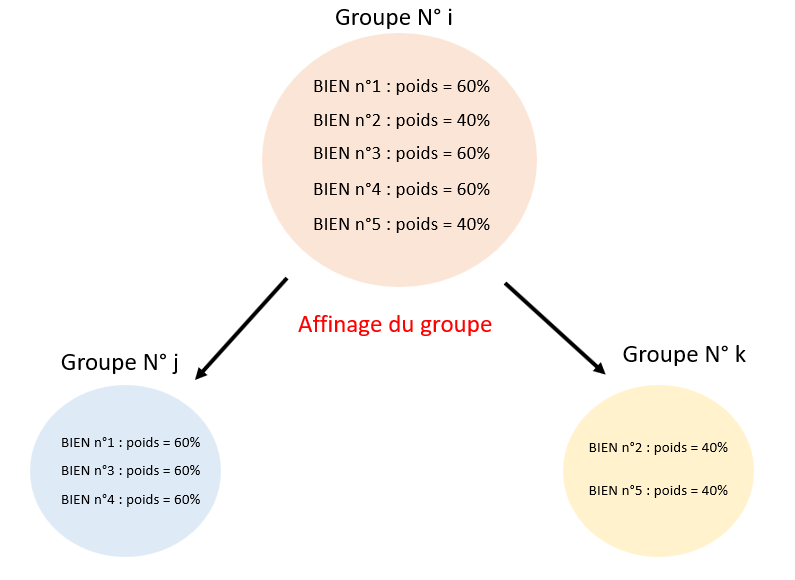

Ensuite, les poids sont recalculés via le même processus d'affinage, jusqu'à ce qu'il n'y ait plus d'anomalie ayant un poids compris entre 100% et 50%

Ainsi, on obtient un nouveau DataFrame qui contient toutes les anomalies de 325 lignes. 

In [168]:
def weight(df):
    df.sort_values(by=['k_means_label'],ignore_index=True, inplace=True)
    
    p=[]
    
    doublons_kmeans = df.pivot_table(index = ['k_means_label'], aggfunc ='size')
    for i in range(len(doublons_kmeans)):
        if(len(df.loc[df['k_means_label'] == doublons_kmeans.index[i]])==1):
            p.append(100)
        else:
            df_i=df[(df['k_means_label']==doublons_kmeans.index[i])]
            for j in range(len(df_i)):
                p.append(ok_address(str(df_i.iloc[j,5]), df_i))    
    
    df["%"]=p
    
    return df

def affinage(df, incr):
    df.sort_values(by=['k_means_label'],ignore_index=True, inplace=True)
    
    k=[]
    
    doublons_kmeans = df.pivot_table(index = ['k_means_label'], aggfunc ='size')
    for i in range(len(doublons_kmeans)):
        df_i=df[(df['k_means_label']==doublons_kmeans.index[i])]
        doublons=df_i.pivot_table(index = ['%'] , aggfunc ='size')
        for j in range(len(df_i)):
            for k in range(len(doublons)):
                df_i.loc[(df_i['%']==doublons.index[k]), 'k_means_label'] = i*incr+k
        df=pd.concat([df_i,df]) 
        df=df.drop_duplicates(subset=['ID'])
    return df

In [169]:
ano_df=df[(df['%'] < 100)]

ano_df=weight(ano_df)
ano_df=affinage(ano_df,10000)

df=pd.concat([ano_df,df]) 
df=df.drop_duplicates(subset=['ID'])
df.sort_values(by=['k_means_label'],ignore_index=True, inplace=True)


C:\Developpement\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Developpement\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Developpement\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Cependant, il reste tout de même les anomalies dont le poids est identique au sein d'un même groupe, avec une incertitude inférieure ou égale à 50%.

On pourrait les refiltrer en améliorant la compréhension des descriptions, ou en faisant une classification en fonction des images, mais aussi en faisant un clustering avec plus de données.

###### Les anomalies sont les suivantes :

In [170]:
anomalies=df[(df['%'] < 100)]
df[(df['%'] < 100)][['ID','DESCRIPTION','%',"k_means_label"]]

,ID,DESCRIPTION,%,k_means_label
0,14bfede0-4b45-11e9-ba7a-0ff7ef4fe44b,Situé dans le secteur des Fronts de Seine au 3...,33.333333,0
2,5a72f890-4b28-11e9-ba7a-0ff7ef4fe44b,Vente appartement 4 pièces de 95m² avec balcon...,66.666667,1
3,7d0bb860-4b14-11e9-961d-3f174c89532b,Vente appartement 4 pièces de 95m² avec balcon...,66.666667,1
1325,06a62800-c1d8-11e9-81e9-5f24299f2ef3,PHÉNIX PATRIMOINE DISPONIBLE TOUS LES JOURS JU...,14.285714,10000
1326,7430bea0-255c-11e7-ac43-73cefd927268,Situé dans une résidence récente de standing u...,14.285714,10000
...,...,...,...,...
2159,a53c6610-84b7-11e7-823a-7b6be8c2c3cd,"Le prix comprend l'eau, les charges trimestrie...",50.000000,2120000
2160,d38694c0-be7e-11e9-81e9-5f24299f2ef3,"Charmant appartement de 2 pièces de 35 m², lib...",50.000000,2120000
2161,88ee98f0-c5a3-11e9-92d3-cb429fb9e457,LEVALLOIS - M°Anatole France Agréable 2 pièces...,33.333333,2130000
2162,d5771190-b232-11e9-9fab-c3006e339e11,"Dans une résidence récente, Jolie studio compr...",66.666667,2130001


##### Par manque de temps j'effectue encore un clustering grâce à K-means présent dans sklearn en prenant en compte le prix :

In [171]:
kmeans = KMeans(n_clusters=elbow(anomalies[['PROPERTY_TYPE','NEW_BUILD','FURNISHED','FIREPLACE','SURFACE','PARKING','HEATING_MODE','FLOOR','FLOOR_COUNT','ELEVATOR','MARKETING_TYPE','PRICE','PRICE_M2','RENTAL_EXPENSES_INCLUDED','DEPOSIT','FEES','EXCLUSIVE_MANDATE','OCCUPIED','DEALER_TYPE']]), random_state=0).fit(anomalies[['PROPERTY_TYPE','NEW_BUILD','FURNISHED','FIREPLACE','SURFACE','PARKING','HEATING_MODE','FLOOR','FLOOR_COUNT','ELEVATOR','MARKETING_TYPE','PRICE','PRICE_M2','RENTAL_EXPENSES_INCLUDED','DEPOSIT','FEES','EXCLUSIVE_MANDATE','OCCUPIED','DEALER_TYPE']])

anomalies["k_means_label"]=kmeans.labels_+1000000000


C:\Developpement\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Dernier affinage

In [172]:
df=pd.concat([anomalies,df]) 
df=df.drop_duplicates(subset=['ID'])
df.sort_values(by=['k_means_label'],ignore_index=True, inplace=True)

ano_df=df[(df['%'] < 100)]

ano_df=weight(ano_df)
ano_df=affinage(ano_df,1000000)
ano_df=weight(ano_df)

df=pd.concat([ano_df,df]) 
df=df.drop_duplicates(subset=['ID'])
df.sort_values(by=['k_means_label'],ignore_index=True, inplace=True)

C:\Developpement\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Developpement\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Developpement\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

## Finalement, j'obtiens un DataFrame contenant l'ensemble des groupes de biens identiques

#### Mon résultat final est le suivant, j'obtiens un nombre de 1783 groupes 

In [173]:
print("Nombre final de doublons : "+str(len(df.pivot_table(index = ['k_means_label'], aggfunc ='size'))))

Nombre final de doublons : 1420


In [174]:
print ("En moyenne une annonce est postée : "+str(2165/len(df.pivot_table(index = ['k_means_label'], aggfunc ='size'))) + " fois" )

En moyenne une annonce est postée : 1.5246478873239437 fois


In [175]:
print("---------------ANNONCES EN VENTE-----------------")
print("Nombre total : "+str(len(df[(df['MARKETING_TYPE'] == 1000)])))
print("Nombre de doublons : "+str(len(df[(df['MARKETING_TYPE'] == 1000)].pivot_table(index = ['k_means_label'], aggfunc ='size'))))
print("Moyenne : " + str(len(df[(df['MARKETING_TYPE'] == 1000)])/len(df[(df['MARKETING_TYPE'] == 1000)].pivot_table(index = ['k_means_label'], aggfunc ='size'))))
print("Max taille doublons : "+ str(max(df[(df['MARKETING_TYPE'] == 1000)].pivot_table(index = ['k_means_label'], aggfunc ='size'))))
print("Le plus gros groupe est le suivant : ")
df[(df['MARKETING_TYPE'] == 1000)&(df['k_means_label'] == df[(df['MARKETING_TYPE'] == 1000)].pivot_table(index = ['k_means_label'] , aggfunc ='size').idxmax() )]

---------------ANNONCES EN VENTE-----------------
Nombre total : 1219
Nombre de doublons : 767
Moyenne : 1.589308996088657
Max taille doublons : 7
Le plus gros groupe est le suivant : 


,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,...,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE,k_means_label,%
782,8c497330-77c4-11e9-8084-55ce2049f05c,https://www.bienici.com/annonce/pericles-25158171,BIEN_ICI,0,0,LEVALLOIS - 2 PIECES - 549 000 EUROS (FAI) A l...,"[""http://photo3.pericles.fr/photo_get.php?S1=3...",65.00,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-05-15T22:37:18.517,0.0,2019-08-22T15:55:25.106,0,639,100.0
783,22171730-776d-11e9-8084-55ce2049f05c,https://www.meilleursagents.com/annonces/achat...,MEILLEURS_AGENTS,0,0,LEVALLOIS - 2 PIECES - 549 000 EUROS (FAI) A l...,"[""http://thumbor.meilleursagents.com/wrg7Sw2II...",65.00,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-05-15T23:56:57.196,0.0,2019-08-22T04:46:29.471,0,639,100.0
784,75cff7f0-9cb8-11e9-a8e6-0de7b497e456,https://www.avendrealouer.fr/vente/levallois-p...,A_VENDRE_A_LOUER,0,0,LEVALLOIS - 2 PIECES - 549 000 EUROS (FAI) A l...,"[""https://cf-medias.avendrealouer.fr/image/_11...",65.00,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-07-02T10:59:25.03,0.0,2019-08-23T22:20:42.323,0,639,100.0
785,5d3186b0-76f6-11e9-8084-55ce2049f05c,https://www.seloger.com/annonces/achat/apparte...,SE_LOGER,0,0,LEVALLOIS - 2 PIÈCES - 549 000 EUROS (FAI) A l...,"[""https://v.seloger.com/s/cdn/x/visuels/0/5/a/...",65.00,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-05-15T09:46:49.325,0.0,2019-08-08T01:47:29.605,0,639,100.0
786,ff1cde70-7728-11e9-adc1-59e67c527828,https://www.leboncoin.fr/ventes_immobilieres/1...,LE_BON_COIN,0,0,LEVALLOIS - 2 PIECES - 549 000 EUROS (FAI)\nA ...,"[""https://img2.leboncoin.fr/ad-image/186f0a977...",65.00,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-05-15T15:49:13.778,0.0,2019-08-11T06:41:41.153,0,639,100.0
787,ceef59c0-583e-11e9-8235-3968d17ac7c9,http://www.logic-immo.com/detail-vente-7e106c7...,LOGIC_IMMO,0,0,LEVALLOIS - 2 PIECES - 549 000 EUROS (FAI) A l...,"[""https://pix.yanport.com/ads/ceef59c0-583e-11...",65.00,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-04-06T07:37:17.93,0.0,2019-06-15T12:16:51.555,0,639,100.0
788,8529c9b0-b4ec-11e8-96a3-b14e4af48faf,https://immobilier.lefigaro.fr/annonces/annonc...,EXPLORIMMO,0,0,LEVALLOIS - MAIRIE - 4 PIECES Appartement 4 pi...,"[""http://photo3.pericles.fr/photo_get.php?S1=3...",66.27,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2018-09-10T11:27:36.988,0.0,2019-07-17T20:54:39.983,2019-07-17,639,100.0


In [176]:
print("---------------ANNONCES EN LOCATION-----------------")
print("Nombre total : "+str(len(df[(df['MARKETING_TYPE'] == 0)])))
print("Nombre de doublons : "+str(len(df[(df['MARKETING_TYPE'] == 0)].pivot_table(index = ['k_means_label'], aggfunc ='size'))))
print("Moyenne : " + str(len(df[(df['MARKETING_TYPE'] == 0)])/len(df[(df['MARKETING_TYPE'] == 0)].pivot_table(index = ['k_means_label'], aggfunc ='size'))))
print("Max taille doublons : "+ str(max(df[(df['MARKETING_TYPE'] == 0)].pivot_table(index = ['k_means_label'], aggfunc ='size'))))
print("Le plus gros groupe est le suivant : ")
df[(df['MARKETING_TYPE'] == 0)&(df['k_means_label'] == df[(df['MARKETING_TYPE'] == 0)].pivot_table(index = ['k_means_label'] , aggfunc ='size').idxmax() )]

---------------ANNONCES EN LOCATION-----------------
Nombre total : 945
Nombre de doublons : 653
Moyenne : 1.447166921898928
Max taille doublons : 7
Le plus gros groupe est le suivant : 


,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,...,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE,k_means_label,%
1889,fd2843a0-9fa7-11e9-ab3e-47ec2b68d334,https://www.leboncoin.fr/locations/1641959648.htm,LE_BON_COIN,300,0,Bonjour je loue mon parking situé rue Victor H...,"[""https://img0.leboncoin.fr/ad-image/9d79ea778...",10.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-07-06T04:38:45.242,0.0,2019-07-21T08:42:07.59,0,274000000,12.5
1890,ca0b0e70-99ea-11e9-af77-a17d8c291169,https://www.leboncoin.fr/locations/1638694765.htm,LE_BON_COIN,300,0,A louer place de parking dans petite résidence...,[],10.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-06-28T21:21:13.353,0.0,2019-07-14T01:05:34.328,0,274000000,12.5
1891,cbdddab0-5bc5-11e9-adc1-59e67c527828,https://www.leboncoin.fr/locations/1598167085.htm,LE_BON_COIN,300,0,Nous mettons en location une place de parking ...,"[""https://pix.yanport.com/ads/cbdddab0-5bc5-11...",12.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-04-10T19:21:04.126,0.0,2019-08-11T11:53:48.13,0,274000000,12.5
1892,67978240-c385-11e9-81e9-5f24299f2ef3,https://www.leboncoin.fr/locations/1662741078.htm,LE_BON_COIN,300,0,place de parking au 77 rue P.V. Couturier \nen...,[],10.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-08-20T20:02:12.682,0.0,2019-08-20T20:02:12.682,0,274000000,12.5
1893,4e7796c0-c600-11e8-a690-852783b5a69d,https://www.paruvendu.fr/immobilier/location/p...,PARU_VENDU,300,0,Location parking à levallois Parking voiture à...,[],10.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2018-10-02T05:02:03.251,0.0,2019-05-05T18:22:45.594,0,274000000,12.5
1894,8e328600-bd06-11e9-81e9-5f24299f2ef3,https://www.leboncoin.fr/locations/1658648817.htm,LE_BON_COIN,300,0,Place de parking privative au sein d’un immeub...,[],10.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-08-12T13:39:03.691,0.0,2019-08-12T13:39:03.691,0,274000000,12.5
1895,ad833000-9b22-11e9-b883-7d9a2d13f1b7,https://www.leboncoin.fr/locations/1639329517.htm,LE_BON_COIN,300,0,Place de parking disponible immédiatement à Le...,[],10.0,0.0,0.0,...,54178039,Levallois-Perret,92300.0,92,2019-06-30T10:34:44.6,0.0,2019-07-15T16:59:01.659,0,274000000,12.5


# Conclusion

Grâce à mon code j'ai pu grossièrement créer des clusters de biens qui semblaient identiques par leurs données.

Cependant, ce code n'est pas achevé, en effet, je pourrai grandement améliorer la lecture et compréhension des descriptions.
Par exemple, je pourrais réaliser une IA qui chercherait les mots importants et qui pourrait les comparer avec l'ensemble des descriptions afin de retourner des groupes dans lesquels les biens ont une description très proche.

J'aurais aussi pu créer une IA comparant les photos postées sur les différents sites afin de retourner l'ensemble des annonces les plus proches visuellement. (utilisation de la bibliothèque tensorflow)

Pour finir, grâce à ces deux améliorations le nombre de doublons aurait été plus précis .

In [177]:
df.pivot_table(index = ['%'] , aggfunc ='size')

%
12.500000        7
16.666667        8
25.000000       20
33.333333       32
50.000000      201
100.000000    1896
dtype: int64